# **Neural Network Parameter Estimation for Covid-19 in Ghana**

Consider the following system of differential equation for the VSSqEI1I2HRVs model with 9 compartments:

dV/dt = aS - muV - bV

dS/dt = wedge + bV − lamdaS + q1Sq − (mu + q)S + cR

dSq/dt = qS − q1Sq − muSq

dE/dt = lamdaS − omegaE − muE

dI1/dt = phi omega E − gamma1I1 − muI1 − dI1

dI2/dt = (1 − phi) omegaE − gamma2I2 − muI2 − dI2

dH/dt = gamma1I1 + gamma2I2 − mH − muH − dH

dR/dt = mH − muR - cR

dVs/dt = f1E + f2I1 + f3I2 − dvVs

where;






| Compartment | Meaning |
|------|-----|
| V | Vaccinated class  |
| S | susceptible  |
|Sq  | self-quarantine susceptible  |
| E | exposed  |
| I1 | infectious with timely diagnosis |
| I2 | infectious with delayed diagnosis |
| H | Hospitalized |
| Vs | The viral spread in the environment |
| R | recovered |
| N | Total human population |

At time t we have
N(t) = V(t)+S(t)+Sq(t)+E(t)+I1(t)+I2(t)+H(t)+R(t)+Vs(t)


The parameters as used in the model include

|Parameter | Meaning
|------|-----|
lamda | beta_eE + beta_i1I1 + beta_i2I2 + beta_vVs
a | Vacination rate. Percentage of the susceptible class that got vaccinated
b | percentage of the vaccinated class that lost their vaccination
c | percentage of recovered class who become susceptible to the virus after time t
wedge | Recruitment rate
q | Self-quarantined rate of the susceptible
q1 | Transition rate of self-quarantined individuals to the susceptible
βe | Transmission rate from the exposed to the susceptible
βi1 | Transmission rate from the infectious with timely diagnosis to the susceptible
βi2 | Transmission rate from the infectious with delayed diagnosis to the susceptible
βv | Transmission rate from the susceptible to the exposed (infected by virus)
1/omega | Incubation period
phi | Proportion of the infectious with timely diagnosis
1/gamma1 | Waiting time of the infectious for timely diagnosis
1/gamma2 | Waiting time of the infectious for delayed diagnosis
mu | Natural human death rate
d | Disease-induced death rate
m | Recovery rate of the hospitalized
f1 | Virus released rate of the exposed
f2 | Virus released rate of the infectious with timely-diagnosis
f3 | Virus released rate of the infectious with delayed-diagnosis
dv | Decay rate of virus in the environment


### Import libraries for generating & visualizing the data

In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patheffects as path_effects
from matplotlib import dates as mdates
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We start by setting some information that we got from the PAPER

In [ ]:
# Initial conditions (from the literature)

N = 30417856 #population size

S0 = 30417848 #everyone starts out as susceptible, except for initial exposed, infected and hospitalized
V0 = 0
Sq0 = 0
E0 = 2
I10 = 2
I20 = 2
H0 = 2
R0 = 0
Vs0 = 0

# A grid of time points (in days)
t = np.linspace(0, 200, 1000) #from day 0 to day 100, generate 1000 points

#parameters from literature
a=22384226/30417856 #Total vaccinated out of total population
b=0.32
c=0.936
wedge=1319.294
q=0.0333
q1=1.6945e-5
beta_e=6.0380e-8
beta_i1=3.8196e-8
beta_i2=1.4286e-5
phi=0.9000
gamma_1=0.5000
gamma_2=0.0714
d=0.006139
f1=0.0178
f2=0.3115
f3=4.6131e-5
m=0.9815
beta_v=4.00199e-8
omega=1/5.2
mu=4.2578e-5
dv=0.3117

### We then write out the system of equations in a function that will calculate the value of each compartment at each time step (in days)

In [ ]:
# The SEIHRV model differential equations.
def deriv(y, t, a,b,c,wedge,q,q1,mu,omega,beta_e,beta_i1,beta_i2,beta_v,phi,gamma_1,gamma_2,dv,m,d,f1,f2,f3):
    V, S, Sq, E, I1, I2, H, R, Vs = y

    lamda = beta_e*E + beta_i1*I1 + beta_i2*I2 + beta_v*Vs
    dVdt = a*S - mu*V - b*V
    dSdt = wedge + b*V - lamda*S + q1*Sq - (mu + q)*S + c*R
    dSqdt = q*S - q1*Sq - mu*Sq
    dEdt = lamda*S - omega*E -mu*E
    dI1dt = phi*omega*E - gamma_1*I1 - mu*I1 - d*I1
    dI2dt = (1-phi)*omega*E - gamma_2*I2 - mu*I2 - d*I2
    dHdt = gamma_1 * I1 + gamma_2*I2 - m*H - mu*H - d*H
    dRdt = m*H - mu*R - c*R
    dVsdt = f1*E + f2*I1 + f3*I2 - dv*Vs

    return dVdt, dSdt, dSqdt, dEdt, dI1dt, dI2dt, dHdt, dRdt, dVsdt

And then we pass the initial conditions to the function to get the values of each compartment for the length we chose before (100 days, 1000 data points per compartment)

In [ ]:
# Initial conditions vector
y0 = V0, S0, Sq0, E0, I10, I20, H0, R0, Vs0

#lamda =  beta_e*E + beta_i1*I1 + beta_i2*I2 + beta_v*V

# Integrate the equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(a,b,c,wedge,q,q1,mu,omega,beta_e,beta_i1,beta_i2,beta_v,phi,gamma_1,gamma_2,dv,m,d,f1,f2,f3))
V, S, Sq, E, I1, I2, H, R, Vs = ret.T

### We can now plot the results

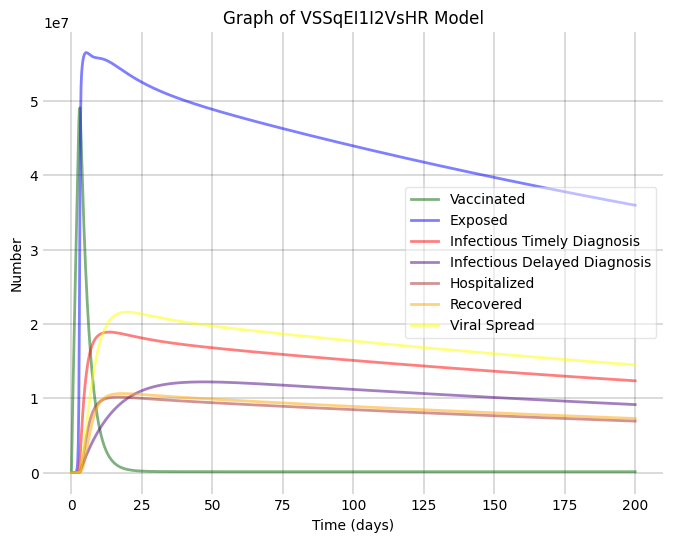

In [ ]:
# Plot the data
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

#ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Susceptible')#, linestyle='dashed')
#ax.plot(t, Sq, 'black', alpha=0.5, lw=2, label='Self-quarantine susceptible')#, linestyle='dashed')
ax.plot(t, V, 'darkgreen', alpha=0.5, lw=2, label='Vaccinated') #, linestyle='dashed'
ax.plot(t, E, 'blue', alpha=0.5, lw=2, label='Exposed') #, linestyle='dashed'
ax.plot(t, I1, 'red', alpha=0.5, lw=2, label='Infectious Timely Diagnosis')
ax.plot(t, I2, 'indigo', alpha=0.5, lw=2, label='Infectious Delayed Diagnosis')
ax.plot(t, H, 'brown', alpha=0.5, lw=2, label='Hospitalized')
ax.plot(t, R, 'orange', alpha=0.5, lw=2, label='Recovered')#, linestyle='dashed')
ax.plot(t, Vs, 'yellow', alpha=0.5, lw=2, label='Viral Spread')


ax.set_xlabel('Time (days)')
ax.set_ylabel('Number')
ax.set_title('Graph of VSSqEI1I2VsHR Model')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

### Saving the result as a csv file

In [ ]:
#save to csv file
Covid19_model_data = np.asarray([t,V, S, Sq, E, I1, I2, H, R, Vs])

np.savetxt("Covid19 Model Data.csv", Covid19_model_data, delimiter=",")

### Great! Now we have data to work with. On to training a neural network.
### I will break down the entire training process into parts.

## 1. Importing libraries

In [ ]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.manual_seed(1234)

## 2. Loading the csv data into Jupyter Environment

In [ ]:
covid_data = genfromtxt('Covid19 Model Data.csv', delimiter=',')

In [ ]:
covid_data

array([[0.00000000e+00, 2.00200200e-01, 4.00400400e-01, ...,
        1.99599600e+02, 1.99799800e+02, 2.00000000e+02],
       [0.00000000e+00, 4.33298072e+06, 8.40772188e+06, ...,
        1.17585929e+05, 1.17586366e+05, 1.17586804e+05],
       [3.04178480e+07, 3.03555331e+07, 3.05615612e+07, ...,
        5.11416609e+04, 5.11418519e+04, 5.11420430e+04],
       ...,
       [2.00000000e+00, 1.94807017e+00, 2.61119369e+00, ...,
        6.92917959e+06, 6.92646413e+06, 6.92375002e+06],
       [0.00000000e+00, 3.48506121e-01, 6.82229547e-01, ...,
        7.28092266e+06, 7.27806775e+06, 7.27521425e+06],
       [0.00000000e+00, 5.41313950e-01, 2.51566760e+00, ...,
        1.44931791e+07, 1.44874968e+07, 1.44818173e+07]])

## 3. Define the class

In [ ]:
class DINN(nn.Module):
    def __init__(self, t, V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data): # remember that the data was saved as [t, S, Sq, E, I1, I2, H, R, V]
        super(DINN, self).__init__()
        # here all the "loading the data" and training is happening
        pass

## 4. Now we need to define some initial conditions

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch


# Now Let's assume we don't know the parameter values:

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


### 6. Normalize the data

Remember that our population size was about 30 mil? Remember that there was only 0 0r 2 person in other compartments and almost 30 mil susceptible people? These drastic variations in values are quite challenging for the network to learn. So we normalize each compartment to be between 0 and 1 for the sake of training

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t, S, Sq, E, I1, I2, H, R, V
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

## 7. A bit "hacky" way to calculate the gradients later
It doesn't seem like PyTorch has an easy way to calculate gradients. The issue is that "grad" only knows how to propagate gradients from a scalar tensor (which our network's output is not), which is why I had to calculate the Jacobian. So instead of calculating the entire jacobian, I'm using this "hacky" way

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t, S, Sq, E, I1, I2, H, R, V
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1


## 8. Let's initialize the network and learnable parameters

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t, S, Sq, E, I1, I2, H, R, V
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (9 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))


### 9. Forcing the parameters to be in a certain range
As I mentioned before, we could let the model learn the parameters from negative infinity to infinity, but why should we? These parameters usually have some plausible range. Here we force these ranges

In [ ]:
#force parameters to be in the range of (-1, 1)
#the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
@property
def a(self):
    return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

@property
def b(self):
    return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

@property
def c(self):
    return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

@property
def wedge(self):
    return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

@property
def q(self):
    return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

@property
def q1(self):
    return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

@property
def mu(self):
    return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

@property
def omega(self):
    return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

@property
def beta_e(self):
    return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

@property
def beta_i1(self):
    return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

@property
def beta_v(self):
    return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

@property
def beta_i2(self):
    return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

@property
def phi(self):
    return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

@property
def gamma_1(self):
    return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

@property
def gamma_2(self):
    return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

@property
def dv(self):
    return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

@property
def m(self):
    return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

@property
def d(self):
    return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

@property
def f1(self):
    return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

@property
def f2(self):
    return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

@property
def f3(self):
    return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t, S, Sq, E, I1, I2, H, R, V
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



        #force parameters to be in the range of (-1, 1)
        #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
        @property
        def a(self):
            return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

        @property
        def b(self):
            return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

        @property
        def c(self):
            return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

        @property
        def wedge(self):
            return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

        @property
        def q(self):
            return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

        @property
        def q1(self):
            return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

        @property
        def mu(self):
            return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

        @property
        def omega(self):
            return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

        @property
        def beta_e(self):
            return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

        @property
        def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

        @property
        def beta_v(self):
            return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

        @property
        def beta_i2(self):
            return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

        @property
        def phi(self):
            return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

        @property
        def gamma_1(self):
            return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

        @property
        def gamma_2(self):
            return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

        @property
        def dv(self):
            return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

        @property
        def m(self):
            return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

        @property
        def d(self):
            return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

        @property
        def f1(self):
            return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

        @property
        def f2(self):
            return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

        @property
        def f3(self):
            return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)



### 10. Creating the neural network

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t, S, Sq, E, I1, I2, H, R, V
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



        #force parameters to be in the range of (-1, 1)
        #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
        @property
        def a(self):
            return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

        @property
        def b(self):
            return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

        @property
        def c(self):
            return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

        @property
        def wedge(self):
            return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

        @property
        def q(self):
            return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

        @property
        def q1(self):
            return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

        @property
        def mu(self):
            return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

        @property
        def omega(self):
            return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

        @property
        def beta_e(self):
            return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

        @property
        def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

        @property
        def beta_v(self):
            return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

        @property
        def beta_i2(self):
            return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

        @property
        def phi(self):
            return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

        @property
        def gamma_1(self):
            return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

        @property
        def gamma_2(self):
            return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

        @property
        def dv(self):
            return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

        @property
        def m(self):
            return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

        @property
        def d(self):
            return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

        @property
        def f1(self):
            return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

        @property
        def f2(self):
            return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

        @property
        def f3(self):
            return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)


    class Net_seihrv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps
        def __init__(self):
            super(DINN.Net_seihrv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.fc9=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs V, S, Sq, E, I1, I2, H, R, Vs

        def forward(self, t_batch):
            seihrv=F.relu(self.fc1(t_batch))
            seihrv=F.relu(self.fc2(seihrv))
            seihrv=F.relu(self.fc3(seihrv))
            seihrv=F.relu(self.fc4(seihrv))
            seihrv=F.relu(self.fc5(seihrv))
            seihrv=F.relu(self.fc6(seihrv))
            seihrv=F.relu(self.fc7(seihrv))
            seihrv=F.relu(self.fc8(seihrv))
            seihrv=F.relu(self.fc9(seihrv))
            seihrv=self.out(seihrv)
            return seihrv


### 11. Now the somewhat complicated part, we create another function that takes the timesteps batch, and pass it to the neural network
We basically want to optimize the neural network and also this function that has the system of equations

In [ ]:
def net_f(self, t_batch):

        #pass the timesteps batch to the neural network
        seihrv_hat = self.net_seihrv(t_batch)

        #organize V,S,Sq,E,I1,I2,H,R,Vs from the neural network's output -- note that these are normalized values -- hence the "hat" part
        V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat = seihrv_hat[:,0], seihrv_hat[:,1], seihrv_hat[:,2], seihrv_hat[:,3], seihrv_hat[:,4], seihrv_hat[:,5], seihrv_hat[:,6], seihrv_hat[:,7], seihrv_hat[:,8]

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t, S, Sq, E, I1, I2, H, R, V
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



    #force parameters to be in the range of (-1, 1)
        #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
        @property
        def a(self):
            return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

        @property
        def b(self):
            return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

        @property
        def c(self):
            return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

        @property
        def wedge(self):
            return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

        @property
        def q(self):
            return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

        @property
        def q1(self):
            return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

        @property
        def mu(self):
            return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

        @property
        def omega(self):
            return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

        @property
        def beta_e(self):
            return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

        @property
        def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

        @property
        def beta_v(self):
            return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

        @property
        def beta_i2(self):
            return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

        @property
        def phi(self):
            return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

        @property
        def gamma_1(self):
            return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

        @property
        def gamma_2(self):
            return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

        @property
        def dv(self):
            return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

        @property
        def m(self):
            return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

        @property
        def d(self):
            return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

        @property
        def f1(self):
            return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

        @property
        def f2(self):
            return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

        @property
        def f3(self):
            return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)


    class Net_seihrv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps
        def __init__(self):
            super(DINN.Net_seihrv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.fc9=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs V, S, Sq, E, I1, I2, H, R, Vs

        def forward(self, t_batch):
            seihrv=F.relu(self.fc1(t_batch))
            seihrv=F.relu(self.fc2(seihrv))
            seihrv=F.relu(self.fc3(seihrv))
            seihrv=F.relu(self.fc4(seihrv))
            seihrv=F.relu(self.fc5(seihrv))
            seihrv=F.relu(self.fc6(seihrv))
            seihrv=F.relu(self.fc7(seihrv))
            seihrv=F.relu(self.fc8(seihrv))
            seihrv=F.relu(self.fc9(seihrv))
            seihrv=self.out(seihrv)
            return seihrv

    def net_f(self, t_batch):

            #pass the timesteps batch to the neural network
            seihrv_hat = self.net_seihrv(t_batch)

            #organize V,S,Sq,E,I1,I2,H,R,Vs from the neural network's output -- note that these are normalized values -- hence the "hat" part
            V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat = seihrv_hat[:,0], seihrv_hat[:,1], seihrv_hat[:,2], seihrv_hat[:,3], seihrv_hat[:,4], seihrv_hat[:,5], seihrv_hat[:,6], seihrv_hat[:,7], seihrv_hat[:,8]

### 12. we now want to get the derivative of each compartment with respect to time (this is why we had to do the "hacky" jacobian part)
We do this to plug in the systems of equations (you'll see in the next step)

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t,V, S, Sq, E, I1, I2, H, R, Vs
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



    #force parameters to be in the range of (-1, 1)
        #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
        @property
        def a(self):
            return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

        @property
        def b(self):
            return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

        @property
        def c(self):
            return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

        @property
        def wedge(self):
            return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

        @property
        def q(self):
            return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

        @property
        def q1(self):
            return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

        @property
        def mu(self):
            return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

        @property
        def omega(self):
            return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

        @property
        def beta_e(self):
            return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

        @property
        def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

        @property
        def beta_v(self):
            return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

        @property
        def beta_i2(self):
            return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

        @property
        def phi(self):
            return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

        @property
        def gamma_1(self):
            return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

        @property
        def gamma_2(self):
            return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

        @property
        def dv(self):
            return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

        @property
        def m(self):
            return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

        @property
        def d(self):
            return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

        @property
        def f1(self):
            return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

        @property
        def f2(self):
            return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

        @property
        def f3(self):
            return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)


    class Net_seihrv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps
        def __init__(self):
            super(DINN.Net_seihrv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.fc9=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs V, S, Sq, E, I1, I2, H, R, Vs

        def forward(self, t_batch):
            seihrv=F.relu(self.fc1(t_batch))
            seihrv=F.relu(self.fc2(seihrv))
            seihrv=F.relu(self.fc3(seihrv))
            seihrv=F.relu(self.fc4(seihrv))
            seihrv=F.relu(self.fc5(seihrv))
            seihrv=F.relu(self.fc6(seihrv))
            seihrv=F.relu(self.fc7(seihrv))
            seihrv=F.relu(self.fc8(seihrv))
            seihrv=F.relu(self.fc9(seihrv))
            seihrv=self.out(seihrv)
            return seihrv

    def net_f(self, t_batch):

            #pass the timesteps batch to the neural network
            seihrv_hat = self.net_seihrv(t_batch)

            #organize V,S,Sq,E,I1,I2,H,R,Vs from the neural network's output -- note that these are normalized values -- hence the "hat" part
            V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat = seihrv_hat[:,0], seihrv_hat[:,1], seihrv_hat[:,2], seihrv_hat[:,3], seihrv_hat[:,4], seihrv_hat[:,5], seihrv_hat[:,6], seihrv_hat[:,7], seihrv_hat[:,8]

            #V_t
            seihrv_hat.backward(self.m1, retain_graph=True)
            V_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #S_t
            seihrv_hat.backward(self.m2, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Sq_t
            seihrv_hat.backward(self.m3, retain_graph=True)
            Sq_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #E_t
            seihrv_hat.backward(self.m4, retain_graph=True)
            E_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I1_t
            seihrv_hat.backward(self.m5, retain_graph=True)
            I1_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I2_t
            seihrv_hat.backward(self.m6, retain_graph=True)
            I2_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #H_t
            seihrv_hat.backward(self.m7, retain_graph=True)
            H_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            seihrv_hat.backward(self.m8, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Vs_t
            seihrv_hat.backward(self.m9, retain_graph=True)
            Vs_hat_t = self.t.grad.clone()
            self.t.grad.zero_()


### 13. We now unnormalize the compartments because we don't actually want the equations to change, we just wanted the network to learn quicker

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t,V, S, Sq, E, I1, I2, H, R, Vs
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



    #force parameters to be in the range of (-1, 1)
        #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
        @property
        def a(self):
            return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

        @property
        def b(self):
            return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

        @property
        def c(self):
            return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

        @property
        def wedge(self):
            return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

        @property
        def q(self):
            return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

        @property
        def q1(self):
            return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

        @property
        def mu(self):
            return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

        @property
        def omega(self):
            return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

        @property
        def beta_e(self):
            return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

        @property
        def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

        @property
        def beta_v(self):
            return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

        @property
        def beta_i2(self):
            return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

        @property
        def phi(self):
            return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

        @property
        def gamma_1(self):
            return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

        @property
        def gamma_2(self):
            return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

        @property
        def dv(self):
            return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

        @property
        def m(self):
            return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

        @property
        def d(self):
            return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

        @property
        def f1(self):
            return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

        @property
        def f2(self):
            return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

        @property
        def f3(self):
            return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)


    class Net_seihrv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps
        def __init__(self):
            super(DINN.Net_seihrv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.fc9=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs V, S, Sq, E, I1, I2, H, R, Vs

        def forward(self, t_batch):
            seihrv=F.relu(self.fc1(t_batch))
            seihrv=F.relu(self.fc2(seihrv))
            seihrv=F.relu(self.fc3(seihrv))
            seihrv=F.relu(self.fc4(seihrv))
            seihrv=F.relu(self.fc5(seihrv))
            seihrv=F.relu(self.fc6(seihrv))
            seihrv=F.relu(self.fc7(seihrv))
            seihrv=F.relu(self.fc8(seihrv))
            seihrv=F.relu(self.fc9(seihrv))
            seihrv=self.out(seihrv)
            return seihrv

    def net_f(self, t_batch):

            #pass the timesteps batch to the neural network
            seihrv_hat = self.net_seihrv(t_batch)

            #organize V,S,Sq,E,I1,I2,H,R,Vs from the neural network's output -- note that these are normalized values -- hence the "hat" part
            V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat = seihrv_hat[:,0], seihrv_hat[:,1], seihrv_hat[:,2], seihrv_hat[:,3], seihrv_hat[:,4], seihrv_hat[:,5], seihrv_hat[:,6], seihrv_hat[:,7], seihrv_hat[:,8]

            #V_t
            seihrv_hat.backward(self.m1, retain_graph=True)
            V_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #S_t
            seihrv_hat.backward(self.m2, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Sq_t
            seihrv_hat.backward(self.m3, retain_graph=True)
            Sq_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #E_t
            seihrv_hat.backward(self.m4, retain_graph=True)
            E_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I1_t
            seihrv_hat.backward(self.m5, retain_graph=True)
            I1_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I2_t
            seihrv_hat.backward(self.m6, retain_graph=True)
            I2_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #H_t
            seihrv_hat.backward(self.m7, retain_graph=True)
            H_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            seihrv_hat.backward(self.m8, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Vs_t
            seihrv_hat.backward(self.m9, retain_graph=True)
            Vs_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #unnormalize
            V = self.V_min + (self.V_max - self.V_min) * V_hat
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            Sq = self.Sq_min + (self.Sq_max - self.Sq_min) * Sq_hat
            E = self.E_min + (self.E_max - self.E_min) * E_hat
            I1 = self.I1_min + (self.I1_max - self.I1_min) * I1_hat
            I2 = self.I2_min + (self.I2_max - self.I2_min) * I2_hat
            H = self.H_min + (self.H_max - self.H_min) * H_hat
            R = self.R_min + (self.R_max - self.R_min) * R_hat
            Vs = self.Vs_min + (self.Vs_max - self.Vs_min) * Vs_hat



### 14. Lastly (almost), we write out the systems of equations we want to learn
These are almost the same as the initial system of equations, except that we have another normalization component here (e.g "/ (self.S_max - self.S_min)"), and also that we use the partial derivates (e.g "S" with respect to time) here. We basically moved the right side of each compartment to the left (hence the negative signs after the derivatives)

In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data):
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t,V, S, Sq, E, I1, I2, H, R, Vs
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_model = self.Net_seihrv()
        self.params = list(self.net_model.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



    #force parameters to be in the range of (-1, 1)
        #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
        @property
        def a(self):
            return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

        @property
        def b(self):
            return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

        @property
        def c(self):
            return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

        @property
        def wedge(self):
            return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

        @property
        def q(self):
            return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

        @property
        def q1(self):
            return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

        @property
        def mu(self):
            return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

        @property
        def omega(self):
            return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

        @property
        def beta_e(self):
            return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

        @property
        def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

        @property
        def beta_v(self):
            return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

        @property
        def beta_i2(self):
            return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

        @property
        def phi(self):
            return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

        @property
        def gamma_1(self):
            return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

        @property
        def gamma_2(self):
            return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

        @property
        def dv(self):
            return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

        @property
        def m(self):
            return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

        @property
        def d(self):
            return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

        @property
        def f1(self):
            return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

        @property
        def f2(self):
            return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

        @property
        def f3(self):
            return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)


    class Net_seihrv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps
        def __init__(self):
            super(DINN.Net_seihrv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.fc9=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs V, S, Sq, E, I1, I2, H, R, Vs

        def forward(self, t_batch):
            seihrv=F.relu(self.fc1(t_batch))
            seihrv=F.relu(self.fc2(seihrv))
            seihrv=F.relu(self.fc3(seihrv))
            seihrv=F.relu(self.fc4(seihrv))
            seihrv=F.relu(self.fc5(seihrv))
            seihrv=F.relu(self.fc6(seihrv))
            seihrv=F.relu(self.fc7(seihrv))
            seihrv=F.relu(self.fc8(seihrv))
            seihrv=F.relu(self.fc9(seihrv))
            seihrv=self.out(seihrv)
            return seihrv

    def net_f(self, t_batch):

            #pass the timesteps batch to the neural network
            seihrv_hat = self.net_seihrv(t_batch)

            #organize V,S,Sq,E,I1,I2,H,R,Vs from the neural network's output -- note that these are normalized values -- hence the "hat" part
            V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat = seihrv_hat[:,0], seihrv_hat[:,1], seihrv_hat[:,2], seihrv_hat[:,3], seihrv_hat[:,4], seihrv_hat[:,5], seihrv_hat[:,6], seihrv_hat[:,7], seihrv_hat[:,8]

            #V_t
            seihrv_hat.backward(self.m1, retain_graph=True)
            V_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #S_t
            seihrv_hat.backward(self.m2, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Sq_t
            seihrv_hat.backward(self.m3, retain_graph=True)
            Sq_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #E_t
            seihrv_hat.backward(self.m4, retain_graph=True)
            E_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I1_t
            seihrv_hat.backward(self.m5, retain_graph=True)
            I1_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I2_t
            seihrv_hat.backward(self.m6, retain_graph=True)
            I2_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #H_t
            seihrv_hat.backward(self.m7, retain_graph=True)
            H_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            seihrv_hat.backward(self.m8, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Vs_t
            seihrv_hat.backward(self.m9, retain_graph=True)
            Vs_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #unnormalize
            V = self.V_min + (self.V_max - self.V_min) * V_hat
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            Sq = self.Sq_min + (self.Sq_max - self.Sq_min) * Sq_hat
            E = self.E_min + (self.E_max - self.E_min) * E_hat
            I1 = self.I1_min + (self.I1_max - self.I1_min) * I1_hat
            I2 = self.I2_min + (self.I2_max - self.I2_min) * I2_hat
            H = self.H_min + (self.H_max - self.H_min) * H_hat
            R = self.R_min + (self.R_max - self.R_min) * R_hat
            Vs = self.Vs_min + (self.Vs_max - self.Vs_min) * Vs_hat


            #let
            self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
            #systems of equations
            f1_hat = V_hat_t - (self.a * S - self.mu * V - self.b * V) / (self.V_max - self.V_min)
            f2_hat = S_hat_t - (self.wedge-self.lamda * S + self.q1 * Sq - (self.mu+self.q)*S)  / (self.S_max - self.S_min)
            f3_hat = Sq_hat_t - (self.q * S - self.q1 * Sq - self.mu*Sq + self.c * R) / (self.Sq_max - self.Sq_min)
            f4_hat = E_hat_t - (self.lamda * S -self.omega * E - self.mu * E) / (self.E_max - self.E_min)
            f5_hat = I1_hat_t - (self.phi * self.omega * E - self.gamma_1*I1 - self.mu * I1 - self.d * I1 ) / (self.I1_max - self.I1_min)
            f6_hat = I2_hat_t - ((1-self.phi)* self.omega * E -self.gamma_2*I2 - self.mu*I2 - self.d*I2) / (self.I2_max - self.I2_min)
            f7_hat = H_hat_t - (self.gamma_1*I1 + self.gamma_2*I2 - self.m*H - self.mu*H - self.d*H) / (self.H_max - self.H_min)
            f8_hat = R_hat_t - (self.m*H - self.mu*R - self.c * R) / (self.R_max - self.R_min)
            f9_hat = Vs_hat_t - (self.f1*E + self.f2*I1 + self.f3*I2 - self.dv*Vs ) / (self.Vs_max - self.Vs_min)

            return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat

### 15. The training process
Here we just create a function called "train", that will take a number of epochs to train for, and will train the network

In [ ]:
def train(self, n_epochs):
      # train
      print('\nstarting training...\n')

      for epoch in range(n_epochs):
        # lists to hold the output (maintain only the final epoch)
        V_pred_list = []
        S_pred_list = []
        Sq_pred_list = []
        E_pred_list = []
        I1_pred_list = []
        I2_pred_list = []
        H_pred_list = []
        R_pred_list = []
        Vs_pred_list = []

        # we pass the timesteps batch into net_f
        f1, f2, f3, f4, f5, f6, f7, f8, f9, V_pred, S_pred, Sq_pred, E_pred, I1_pred, I2_pred, H_pred, R_pred, Vs_pred = self.net_f(self.t_batch)

        self.optimizer.zero_grad() #zero grad

        #append the values to plot later (note that we unnormalize them here for plotting)
        V_pred_list.append(self.V_min + (self.V_max - self.V_min) * V_pred)
        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
        Sq_pred_list.append(self.Sq_min + (self.Sq_max - self.Sq_min) * Sq_pred)
        E_pred_list.append(self.E_min + (self.E_max - self.E_min) * E_pred)
        I1_pred_list.append(self.I1_min + (self.I1_max - self.I1_min) * I1_pred)
        I2_pred_list.append(self.I2_min + (self.I2_max - self.I2_min) * I2_pred)
        H_pred_list.append(self.H_min + (self.H_max - self.H_min) * H_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
        Vs_pred_list.append(self.Vs_min + (self.Vs_max - self.Vs_min) * Vs_pred)


        #calculate the loss --- MSE of the neural networks output and each compartment
        loss = (torch.mean(torch.square(self.V_hat - V_pred))+
                torch.mean(torch.square(self.S_hat - S_pred))+
                torch.mean(torch.square(self.Sq_hat - Sq_pred))+
                torch.mean(torch.square(self.E_hat - E_pred))+
                torch.mean(torch.square(self.I1_hat - I1_pred))+
                torch.mean(torch.square(self.I2_hat - I2_pred))+
                torch.mean(torch.square(self.H_hat - H_pred))+
                torch.mean(torch.square(self.R_hat - R_pred))+
                torch.mean(torch.square(self.Vs_hat - Vs_pred))+

                torch.mean(torch.square(f1))+
                torch.mean(torch.square(f2))+
                torch.mean(torch.square(f3))+
                torch.mean(torch.square(f4))+
                torch.mean(torch.square(f5))+
                torch.mean(torch.square(f6))+
                torch.mean(torch.square(f7))+
                torch.mean(torch.square(f8))+
                torch.mean(torch.square(f9))
                )

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
        self.losses.append(loss.item())

        if epoch % 4000 == 0:
          print('\nEpoch ', epoch, 'Loss:', loss.item())

          print('a: (goal 22384226/30417856 ', self.a)
          print('b: (goal 0.32 ', self.b)
          print('c: (goal 0.936 ', self.c)
          print('wedge: (goal 1319.294 ', self.wedge)
          print('q: (goal 0.0333 ', self.q)
          print('q1: (goal 1.6945e-5 ', self.q1)
          print('beta_e: (goal 6.0380e-8 ', self.beta_e)
          print('beta_i1: (goal 3.8196e-8 ', self.beta_i1)
          print('beta_i2: (goal 1.4286e-5 ', self.beta_i2)
          print('phi: (goal 0.9000 ', self.phi)
          print('gamma_1: (goal 0.5000 ', self.gamma_1)
          print('gamma_2: (goal 0.0714 ', self.gamma_2)
          print('d: (goal 0.006139 ', self.d)
          print('f1: (goal 0.0178 ', self.f1)
          print('f2: (goal 0.3115 ', self.f2)
          print('f3: (goal 4.6131e-5 ', self.f3)
          print('m: (goal 0.9815 ', self.m)
          print('beta_v: (goal 4.00199e-8 ', self.beta_v)
          print('omega: (goal 1/5.2 ', self.omega)
          print('mu: (goal 4.2578e5 ', self.mu)
          print('dv: (goal 0.3117 ', self.dv)


          print('#################################')

      return V_pred_list, S_pred_list, Sq_pred_list, E_pred_list, I1_pred_list, I2_pred_list, H_pred_list, R_pred_list, Vs_pred_list



In [ ]:
class DINN(nn.Module):
    def __init__(self, t,V_data, S_data, Sq_data, E_data, I1_data, I2_data, H_data, R_data, Vs_data): #ttrue data for each compartment
        super(DINN, self).__init__()

        self.N = 30417856 #population size

        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch

        #for the compartments we just need to convert them into tensors
        self.V = torch.tensor(V_data)
        self.S = torch.tensor(S_data)
        self.Sq = torch.tensor(Sq_data)
        self.E = torch.tensor(E_data)
        self.I1 = torch.tensor(I1_data)
        self.I2 = torch.tensor(I2_data)
        self.H = torch.tensor(H_data)
        self.R = torch.tensor(R_data)
        self.Vs = torch.tensor(Vs_data)

        self.losses = [] # here I saved the model's losses per epoch

        #let
        #self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
        #setting the parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.wedge_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.q1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.omega_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_e_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_i2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.phi_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.gamma_2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.dv_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.d_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.f3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))


        #t,V, S, Sq, E, I1, I2, H, R, Vs
        #find values for normalization
        self.V_max = max(self.V)
        self.S_max = max(self.S)
        self.Sq_max = max(self.Sq)
        self.E_max = max(self.E)
        self.I1_max = max(self.I1)
        self.I2_max = max(self.I2)
        self.H_max = max(self.H)
        self.R_max = max(self.R)
        self.Vs_max = max(self.Vs)

        self.V_min = min(self.V)
        self.S_min = min(self.S)
        self.Sq_min = min(self.Sq)
        self.E_min = min(self.E)
        self.I1_min = min(self.I1)
        self.I2_min = min(self.I2)
        self.H_min = min(self.H)
        self.R_min = min(self.R)
        self.Vs_min = min(self.Vs)

        #normalize
        self.V_hat = (self.V - self.V_min) / (self.V_max - self.V_min)
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.Sq_hat = (self.Sq - self.Sq_min) / (self.Sq_max - self.Sq_min)
        self.E_hat = (self.E - self.E_min) / (self.E_max - self.E_min)
        self.I1_hat = (self.I1 - self.I1_min) / (self.I1_max - self.I1_min)
        self.I2_hat = (self.I2 - self.I2_min) / (self.I2_max - self.I2_min)
        self.H_hat = (self.H - self.H_min) / (self.H_max - self.H_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)
        self.Vs_hat = (self.Vs - self.Vs_min) / (self.Vs_max - self.Vs_min)

        #matrices (x8 for S, Sq, E, I1, I2, H, R, V) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #NN
        self.net_seihrv = self.Net_seihrv()
        self.params = list(self.net_seihrv.parameters())
        self.params.extend(list([self.a_tilda,self.b_tilda,self.c_tilda,self.wedge_tilda, self.q_tilda, self.q1_tilda, self.mu_tilda, self.omega_tilda,
                                 self.beta_e_tilda, self.beta_i1_tilda, self.beta_i2_tilda,self.beta_v_tilda, self.phi_tilda,
                                 self.gamma_1_tilda, self.gamma_2_tilda, self.dv_tilda, self.m_tilda, self.d_tilda, self.f1_tilda,
                                 self.f2_tilda, self.f3_tilda
        ]))



    #force parameters to be in the range of (-1, 1)
    #the torch.clamp() function restricts the output of torch.tanh() to the range (-1, 1).
    @property
    def a(self):
        return torch.clamp(torch.tanh(self.a_tilda), -1.0, 1.0)

    @property
    def b(self):
        return torch.clamp(torch.tanh(self.b_tilda), -1.0, 1.0)

    @property
    def c(self):
        return torch.clamp(torch.tanh(self.c_tilda), -1.0, 1.0)

    @property
    def wedge(self):
        return torch.clamp(torch.tanh(self.wedge_tilda), -1.0, 1.0)

    @property
    def q(self):
        return torch.clamp(torch.tanh(self.q_tilda), -1.0, 1.0)

    @property
    def q1(self):
        return torch.clamp(torch.tanh(self.q1_tilda), -1.0, 1.0)

    @property
    def mu(self):
        return torch.clamp(torch.tanh(self.mu_tilda), -1.0, 1.0)

    @property
    def omega(self):
        return torch.clamp(torch.tanh(self.omega_tilda), -1.0, 1.0)

    @property
    def beta_e(self):
        return torch.clamp(torch.tanh(self.beta_e_tilda), -1.0, 1.0)

    @property
    def beta_i1(self):
            return torch.clamp(torch.tanh(self.beta_i1_tilda), -1.0, 1.0)

    @property
    def beta_v(self):
        return torch.clamp(torch.tanh(self.beta_v_tilda), -1.0, 1.0)

    @property
    def beta_i2(self):
        return torch.clamp(torch.tanh(self.beta_i2_tilda), -1.0, 1.0)

    @property
    def phi(self):
        return torch.clamp(torch.tanh(self.phi_tilda), -1.0, 1.0)

    @property
    def gamma_1(self):
        return torch.clamp(torch.tanh(self.gamma_1_tilda), -1.0, 1.0)

    @property
    def gamma_2(self):
        return torch.clamp(torch.tanh(self.gamma_2_tilda), -1.0, 1.0)

    @property
    def dv(self):
        return torch.clamp(torch.tanh(self.dv_tilda), -1.0, 1.0)

    @property
    def m(self):
        return torch.clamp(torch.tanh(self.m_tilda), -1.0, 1.0)

    @property
    def d(self):
        return torch.clamp(torch.tanh(self.d_tilda), -1.0, 1.0)

    @property
    def f1(self):
        return torch.clamp(torch.tanh(self.f1_tilda), -1.0, 1.0)

    @property
    def f2(self):
        return torch.clamp(torch.tanh(self.f2_tilda), -1.0, 1.0)

    @property
    def f3(self):
        return torch.clamp(torch.tanh(self.f3_tilda), -1.0, 1.0)


    class Net_seihrv(nn.Module): # input = [[t1], [t2]...[t100]] -- that is, a batch of timesteps
        def __init__(self):
            super(DINN.Net_seihrv, self).__init__()

            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.fc9=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs V, S, Sq, E, I1, I2, H, R, Vs

        def forward(self, t_batch):
            seihrv=F.relu(self.fc1(t_batch))
            seihrv=F.relu(self.fc2(seihrv))
            seihrv=F.relu(self.fc3(seihrv))
            seihrv=F.relu(self.fc4(seihrv))
            seihrv=F.relu(self.fc5(seihrv))
            seihrv=F.relu(self.fc6(seihrv))
            seihrv=F.relu(self.fc7(seihrv))
            seihrv=F.relu(self.fc8(seihrv))
            seihrv=F.relu(self.fc9(seihrv))
            seihrv=self.out(seihrv)
            return seihrv

    def net_f(self, t_batch):

            #pass the timesteps batch to the neural network
            seihrv_hat = self.net_seihrv(t_batch)

            #organize V,S,Sq,E,I1,I2,H,R,Vs from the neural network's output -- note that these are normalized values -- hence the "hat" part
            V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat = seihrv_hat[:,0], seihrv_hat[:,1], seihrv_hat[:,2], seihrv_hat[:,3], seihrv_hat[:,4], seihrv_hat[:,5], seihrv_hat[:,6], seihrv_hat[:,7], seihrv_hat[:,8]

            #V_t
            seihrv_hat.backward(self.m1, retain_graph=True)
            V_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #S_t
            seihrv_hat.backward(self.m2, retain_graph=True)
            S_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Sq_t
            seihrv_hat.backward(self.m3, retain_graph=True)
            Sq_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #E_t
            seihrv_hat.backward(self.m4, retain_graph=True)
            E_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I1_t
            seihrv_hat.backward(self.m5, retain_graph=True)
            I1_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #I2_t
            seihrv_hat.backward(self.m6, retain_graph=True)
            I2_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #H_t
            seihrv_hat.backward(self.m7, retain_graph=True)
            H_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #R_t
            seihrv_hat.backward(self.m8, retain_graph=True)
            R_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #Vs_t
            seihrv_hat.backward(self.m9, retain_graph=True)
            Vs_hat_t = self.t.grad.clone()
            self.t.grad.zero_()

            #unnormalize
            V = self.V_min + (self.V_max - self.V_min) * V_hat
            S = self.S_min + (self.S_max - self.S_min) * S_hat
            Sq = self.Sq_min + (self.Sq_max - self.Sq_min) * Sq_hat
            E = self.E_min + (self.E_max - self.E_min) * E_hat
            I1 = self.I1_min + (self.I1_max - self.I1_min) * I1_hat
            I2 = self.I2_min + (self.I2_max - self.I2_min) * I2_hat
            H = self.H_min + (self.H_max - self.H_min) * H_hat
            R = self.R_min + (self.R_max - self.R_min) * R_hat
            Vs = self.Vs_min + (self.Vs_max - self.Vs_min) * Vs_hat


            #let
            self.lamda = self.beta_e*E + self.beta_i1*I1 + self.beta_i2*I2 + self.beta_v*Vs
            #systems of equations
            f1_hat = V_hat_t - (self.a * S - self.mu * V - self.b * V) / (self.V_max - self.V_min)
            f2_hat = S_hat_t - (self.wedge-self.lamda * S + self.q1 * Sq - (self.mu+self.q)*S)  / (self.S_max - self.S_min)
            f3_hat = Sq_hat_t - (self.q * S - self.q1 * Sq - self.mu*Sq + self.c * R) / (self.Sq_max - self.Sq_min)
            f4_hat = E_hat_t - (self.lamda * S -self.omega * E - self.mu * E) / (self.E_max - self.E_min)
            f5_hat = I1_hat_t - (self.phi * self.omega * E - self.gamma_1*I1 - self.mu * I1 - self.d * I1 ) / (self.I1_max - self.I1_min)
            f6_hat = I2_hat_t - ((1-self.phi)* self.omega * E -self.gamma_2*I2 - self.mu*I2 - self.d*I2) / (self.I2_max - self.I2_min)
            f7_hat = H_hat_t - (self.gamma_1*I1 + self.gamma_2*I2 - self.m*H - self.mu*H - self.d*H) / (self.H_max - self.H_min)
            f8_hat = R_hat_t - (self.m*H - self.mu*R - self.c * R) / (self.R_max - self.R_min)
            f9_hat = Vs_hat_t - (self.f1*E + self.f2*I1 + self.f3*I2 - self.dv*Vs ) / (self.Vs_max - self.Vs_min)

            return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, V_hat, S_hat, Sq_hat, E_hat, I1_hat, I2_hat, H_hat, R_hat, Vs_hat
    #epochs
    def train(self, n_epochs):
      # train
      print('\nstarting training...\n')

      for epoch in range(n_epochs):
        # lists to hold the output (maintain only the final epoch)
        V_pred_list = []
        S_pred_list = []
        Sq_pred_list = []
        E_pred_list = []
        I1_pred_list = []
        I2_pred_list = []
        H_pred_list = []
        R_pred_list = []
        Vs_pred_list = []

        # we pass the timesteps batch into net_f
        f1, f2, f3, f4, f5, f6, f7, f8, f9, V_pred, S_pred, Sq_pred, E_pred, I1_pred, I2_pred, H_pred, R_pred, Vs_pred = self.net_f(self.t_batch)

        self.optimizer.zero_grad() #zero grad

        #append the values to plot later (note that we unnormalize them here for plotting)
        V_pred_list.append(self.V_min + (self.V_max - self.V_min) * V_pred)
        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred)
        Sq_pred_list.append(self.Sq_min + (self.Sq_max - self.Sq_min) * Sq_pred)
        E_pred_list.append(self.E_min + (self.E_max - self.E_min) * E_pred)
        I1_pred_list.append(self.I1_min + (self.I1_max - self.I1_min) * I1_pred)
        I2_pred_list.append(self.I2_min + (self.I2_max - self.I2_min) * I2_pred)
        H_pred_list.append(self.H_min + (self.H_max - self.H_min) * H_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
        Vs_pred_list.append(self.Vs_min + (self.Vs_max - self.Vs_min) * Vs_pred)


        #calculate the loss --- MSE of the neural networks output and each compartment
        loss = (torch.mean(torch.square(self.V_hat - V_pred))+
                torch.mean(torch.square(self.S_hat - S_pred))+
                torch.mean(torch.square(self.Sq_hat - Sq_pred))+
                torch.mean(torch.square(self.E_hat - E_pred))+
                torch.mean(torch.square(self.I1_hat - I1_pred))+
                torch.mean(torch.square(self.I2_hat - I2_pred))+
                torch.mean(torch.square(self.H_hat - H_pred))+
                torch.mean(torch.square(self.R_hat - R_pred))+
                torch.mean(torch.square(self.Vs_hat - Vs_pred))+

                torch.mean(torch.square(f1))+
                torch.mean(torch.square(f2))+
                torch.mean(torch.square(f3))+
                torch.mean(torch.square(f4))+
                torch.mean(torch.square(f5))+
                torch.mean(torch.square(f6))+
                torch.mean(torch.square(f7))+
                torch.mean(torch.square(f8))+
                torch.mean(torch.square(f9))
                )

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        # append the loss value (we call "loss.item()" because we just want the value of the loss and not the entire computational graph)
        self.losses.append(loss.item())

        if epoch % 4000 == 0:
          print('\nEpoch ', epoch, 'MSE:', round(loss.item(),4))

          print('a: (goal 22384226/30417856 ', self.a)
          print('b: (goal 0.32 ', self.b)
          print('c: (goal 0.936 ', self.c)
          print('wedge: (goal 1319.294 ', self.wedge)
          print('q: (goal 0.0333 ', self.q)
          print('q1: (goal 1.6945e-5 ', self.q1)
          print('beta_e: (goal 6.0380e-8 ', self.beta_e)
          print('beta_i1: (goal 3.8196e-8 ', self.beta_i1)
          print('beta_i2: (goal 1.4286e-5 ', self.beta_i2)
          print('phi: (goal 0.9000 ', self.phi)
          print('gamma_1: (goal 0.5000 ', self.gamma_1)
          print('gamma_2: (goal 0.0714 ', self.gamma_2)
          print('d: (goal 0.006139 ', self.d)
          print('f1: (goal 0.0178 ', self.f1)
          print('f2: (goal 0.3115 ', self.f2)
          print('f3: (goal 4.6131e-5 ', self.f3)
          print('m: (goal 0.9815 ', self.m)
          print('beta_v: (goal 4.00199e-8 ', self.beta_v)
          print('omega: (goal 1/5.2 ', self.omega)
          print('mu: (goal 4.2578e-5 ', self.mu)
          print('dv: (goal 0.3117 ', self.dv)


          print('#################################')

      return V_pred_list, S_pred_list, Sq_pred_list, E_pred_list, I1_pred_list, I2_pred_list, H_pred_list, R_pred_list, Vs_pred_list


### 16. Training the network

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error
import numpy as np

In [ ]:
%%time

dinn = DINN(covid_data[0], covid_data[1], covid_data[2], covid_data[3],
            covid_data[4], covid_data[5], covid_data[6], covid_data[7],
           covid_data[8], covid_data[9]) #in the form of [t,V,S,Sq,E,I1,I2,H,R,Vs]

learning_rate = 1e-3 #1e-6
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-1, step_size_up=4000, mode="exp_range",
                                              gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

V_pred_list, S_pred_list, Sq_pred_list, E_pred_list, I1_pred_list, I2_pred_list, H_pred_list, R_pred_list, Vs_pred_list = dinn.train(100000) #train




starting training...


Epoch  0 MSE: 83727710241.2567
a: (goal 22384226/30417856  tensor([0.6153], grad_fn=<ClampBackward1>)
b: (goal 0.32  tensor([0.3916], grad_fn=<ClampBackward1>)
c: (goal 0.936  tensor([0.6488], grad_fn=<ClampBackward1>)
wedge: (goal 1319.294  tensor([0.2754], grad_fn=<ClampBackward1>)
q: (goal 0.0333  tensor([0.6474], grad_fn=<ClampBackward1>)
q1: (goal 1.6945e-5  tensor([0.7017], grad_fn=<ClampBackward1>)
beta_e: (goal 6.0380e-8  tensor([0.0920], grad_fn=<ClampBackward1>)
beta_i1: (goal 3.8196e-8  tensor([0.5041], grad_fn=<ClampBackward1>)
beta_i2: (goal 1.4286e-5  tensor([0.1013], grad_fn=<ClampBackward1>)
phi: (goal 0.9000  tensor([0.0992], grad_fn=<ClampBackward1>)
gamma_1: (goal 0.5000  tensor([0.3141], grad_fn=<ClampBackward1>)
gamma_2: (goal 0.0714  tensor([0.5636], grad_fn=<ClampBackward1>)
d: (goal 0.006139  tensor([0.2761], grad_fn=<ClampBackward1>)
f1: (goal 0.0178  tensor([0.1983], grad_fn=<ClampBackward1>)
f2: (goal 0.3115  tensor([0.6114], grad_fn=<

### 17. Plotting the losses and values

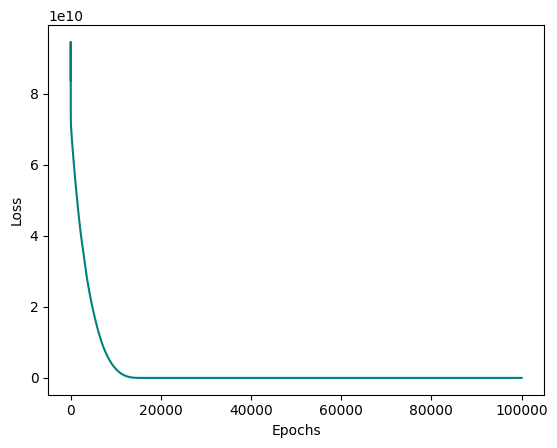

In [ ]:
plt.plot(dinn.losses[0:], color = 'teal')
#plt.title('Plot of the Epoch vrs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');


# Plotting the predicted Vs Actual Compartments

In [ ]:
#fig = plt.figure(figsize=(10,8))
#ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
#ax.set_facecolor('xkcd:white')


#ax.plot(covid_data[0], covid_data[1], 'lavender', alpha=0.5, lw=2, label='Vaccinated')
#ax.plot(covid_data[0], V_pred_list[0].detach().numpy(), 'maroon', alpha=0.9, lw=2, label='Predicted Vaccinated', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[2], 'violet', alpha=0.5, lw=2, label='Susceptible')
#ax.plot(covid_data[0], S_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[3], 'darkgreen', alpha=0.5, lw=2, label='Self-Quarantine Susceptible')
#ax.plot(covid_data[0], Sq_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Self-Quarantine Susceptible Prediction', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[4], 'blue', alpha=0.5, lw=2, label='Exposed')
#ax.plot(covid_data[0], E_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Predicted Exposed', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[5], 'red', alpha=0.5, lw=2, label='Infectious Timely Diagnosis')
#ax.plot(covid_data[0], I1_pred_list[0].detach().numpy(), 'pink', alpha=0.9, lw=2, label='Infectious Timely Diagnosis Prediction', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[6], 'indigo', alpha=0.5, lw=2, label='Infectious Delayed Diagnosis')
#ax.plot(covid_data[0], I2_pred_list[0].detach().numpy(), 'purple', alpha=0.9, lw=2, label='Infectious Delayed Diagnosis Prediction', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[7], 'brown', alpha=0.5, lw=2, label='Hospitalized')
#ax.plot(covid_data[0], H_pred_list[0].detach().numpy(), 'khaki', alpha=0.9, lw=2, label='Hospitalized Prediction', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[8], 'orange', alpha=0.5, lw=2, label='Rocovered')
#ax.plot(covid_data[0], R_pred_list[0].detach().numpy(), 'coral', alpha=0.9, lw=2, label='Rocovered Prediction', linestyle='dashed')

#ax.plot(covid_data[0], covid_data[9], 'yellow', alpha=0.5, lw=2, label='Viral Spread')
#ax.plot(covid_data[0], Vs_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Viral Spread Prediction', linestyle='dashed')



#ax.set_title('Covid 19 Model')
#ax.set_xlabel('Time (days)')
#ax.set_ylabel('Number')
#ax.yaxis.set_tick_params(length=0)
#ax.xaxis.set_tick_params(length=0)
#ax.grid(which='major', c='black', lw=0.2, ls='-')
#legend = ax.legend()
#legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
#    ax.spines[spine].set_visible(False)
#plt.show();

# <h1 style='text-align: center;'> The End </h1>
# <h1 style='text-align: center;'> Thank You </h1>